# Section 5.1 Model Comparison Methods
*How can we determine which model better fits our needs?*

In [4]:
import os
import time

import arviz as az
import numpy as np
import pymc3 as pm
import scipy.stats as stats


np.random.seed(0)

# Path Constants
if os.path.split(os.getcwd())[-1] != "notebooks":
    os.chdir(os.path.join(".."))

from utils import metropolis_hastings

NETCDF_DIR = "inference_data"

## Learning Objectives
* Understanding of how to interpret WAIC, PSIS-LOO numerical metrics
* Understanding of how to interpret plot_compare

## Infinite parameters and Infinite Models
As Bayesian modelers not only do we have to handle infinite model parameters, we also have to handle infinite model defnitions.

Take our water example from Section 1.3. 
$$
\theta = Uniform(0,1) \\
p_{water} = Binom(\theta)
$$
In this model we're evaulating not just one possible proportion of water on a planet, but an infinite amount of proportions from 0 to 1.

But this begs the question why 0 to 1, or why even this model? This is also a valid model

$$
\theta = Beta(1,5) \\
p_{water} = Binom(\theta)
$$

as is this model

$$ 
\theta = Uniform(0,1) \\
\sigma = Uniform(0,100) \\
p_{water} = Norm(\theta, \sigma)
$$

### How do we pick?
The flexibility to design whatever model you like is simultaneously the beauty and challenge of Bayesian modeling. While this philosophy is nice, for the practioner there still is the question of which model to choose. The reason this question is particularly challenging in Bayesian Statistics because we don't get just one prediction, we get an infinite amount of predictions in a distribution. However this does not mean that Bayesian analysis is not suspect to phenomena such as overfitting or excess complexity.

Luckily there tools that help. In particular we'll cover *Widely Applicable Information Criterion* and how it's used in cojunction with `plot_compare`.

### A history of Information Theory
When you hear Information Criterion you usually hear the words entropy, divergence, and deviance.  Let's briefly cover how these ideas build upon each other by walking through information theory.


\*Note:* This section heavily draws from Richard McElreath's examples. We'll be covering the material at a high level to get a full understanding we highly recommend his  [lectures](https://www.youtube.com/watch?v=gjrsYDJbRh0) and [books](https://www.amazon.com/Statistical-Rethinking-Bayesian-Examples-Chapman/dp/1482253445/). 


To restate our prior question "If have  3, or 5, or 10, estimates of the truth (also called models) which most usefully explains the truth, given the truth is also uncertain?"

Over the years a number of folks have contributed mathematical tools that help answer this question. In short the we go in this order

1. How do we quantify uncertainty? (Information Entropy)
2. How do we quantify the additional uncertainty added from an estimate when we know the truth? (KL Divergence)
3. How do we estimate the additional uncertainty added from an estimate when we don't know the truth? (Deviance)
4. How do we make sure we're ensure were underestimating uncertainty with complex models? (Information Criteria)

This section is quite heavy of math. However it is not critical to understand the fine details, but more so the path of thinking.

#### *Information Entropy*: Quantifying Uncertainty
Weather is uncertain, and dice rolls are uncertain. But weather in certain areas is delightfully consistent, like my hometown of Orange County, and "loaded" are designed to be inconsistent.

Information Entropy is a summarization of our uncertainty through the following formula  
$$ H(p) = -\sum_{n=1}^{N} p_{i}log(p_{i})$$

#### *Divergence*: Quantifying additional uncertainty added from estimations of the truth
Now that we can quantify the uncertainty in the distribution of reality, we can compare the uncertainty in the distribution our model to see how far off we are. The formula is as follows, where $p$ is the truth and $q$ is the estimate

$$D_{kl} = -\sum_{n=1}^{N} p_{i}(log(q_{i}) - log(p_{i}))$$

This is the idea of **divergence**, a measurement of the "distance" between two distributions. One important note this distance is not symmetric. For some quick intuition It was way more surprising for me to go from always sunny Los Angeles and experience snow in Wisconsin, than it is for a native Wisconsite to see sun in Los Angeles. People in Los Angeles only see sun, people in Wisconsin see sun and snow, therefore a Los Angeles is much farther removed from the reality of a mixed sunny/snowy climate, than a Wisconsinite is to an always sunny climate.

#### *Deviance*: Estimating additional uncertainty because we don't know the truth using Deviance
If we knew the truth then there wouldn't be a point to this tutorial, or the entire field of Statistics/Machine Learning. Since we don't know the truth this unfortunately means we can't use the formula above, but through some clever thinking it turns out you don't need to know the truth to compare two models, just how far off one model is relative from another. By using the truth data (The weather in the past), and a model estimates, its possible to calculate **Deviance** which is an estimate of the divergence.

Taken from Osvaldo Martin's book [Bayesian Data Analysis in Python](https://www.packtpub.com/big-data-and-business-intelligence/bayesian-analysis-python-second-edition)

$$D_{kl}(p \mid \mid q) - D_{kl}(q \mid \mid r) \approx \sum_{n=1}^{N} log(q_{i}) - \sum_{n=1}^{N} log(r_{i})$$
Remember this works because we're not trying to see how far one model is from the truth, we're just trying to see how far two models are from the truth *relative to each other*

#### *Information Criterion*: Making sure we're not overfitting to observed data using complex models
Deviance uses data that has been observed to make an estimation. As it turns out it's impossible to use data you haven't seen because you haven't seen it. As it also turns out if you make models complex you can explain anything perfectly. *Information Criterion* uses both estimates of deviance and a penalizing for excess model complexity to "score" a model fit.


## Information Criterion in detail
Information Criterion calcuations are composed of two terms

1. Estimate of a the deviance
2. Number of parameters in the model

Below is the summarized formula for Widely Applicable Information Criterion (Also Watanabe–Akaike information criterion) 

$$WAIC = -2 lppd + p_{WAIC}$$ 

*lppd* stands for log pointwise predictive density, and $p_{WAIC}$ is an effective number of the parameters. Between the two we get an estimate of model "accuracy" balanced by model complexity

### What about AIC, BIC, DIC?
There are numerous variations of Information Criterion (IC) estimates. However due to assumptions in the calculations some of the IC's estimations are less general than others. As the name suggests Widely Applicable IC, is well, the most widely applicable. Richard McElreath goes through the full explanation in his book.



## Compare
Compare Dataframe is a handy way of comparing a set of models using Information Criteria.

In [25]:
data1 = az.load_arviz_data("non_centered_eight")
data2 = az.load_arviz_data("centered_eight")
compare_dict = {"non centered": data1, "centered": data2}
az.compare(compare_dict)

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
non centered,61.3022,0.820067,0,0.515575,2.54078,0,0,deviance
centered,61.4296,0.919548,0.127437,0.484425,2.50275,0.106882,0,deviance


In [26]:
az.compare(compare_dict, scale="log")

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
non centered,-30.6511,0.820067,0,0.515568,1.25817,0,0,log
centered,-30.7148,0.919548,0.0637183,0.484432,1.23771,0.0534409,0,log


Here we load two versions 
In order
1. WAIC is the WAIC 
2. p_waic is the estimate of number of parameters
3. Weight is the Akaike weight which can be used for model average
4. se is the standard error of the WAIC estimate (Remember WAIC estimates are also distributions)
5. dse is the standard error of the top ranked WAIC and each model
6. Warning that WAIC may be failing
7. Scale is the "multiplier" on the in sample deviation portion of WAIC

## Plot Compare
ArviZ provides plot compare as a way to summarize the results of WAIC, and in particular when comparing multiple models. 

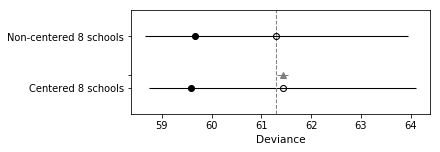

In [29]:
model_compare = az.compare({'Centered 8 schools': az.load_arviz_data('centered_eight'),
                           'Non-centered 8 schools': az.load_arviz_data('non_centered_eight')})
az.plot_compare(model_compare, plot_ic_diff=True, plot_standard_error=True, insample_dev=True)

* The open circles are the WAIC values of each model. This includes both the in sample deviance and the model complexity penalization.
* The dark circles are in sample deviance. These measure how well the model fits the data.
* The standard error of the differences ofplotted in by the gray triangles and gray lines. This is the standard error of the different 
* The dark gray lines are the standard error of WAIC

All except WAIC can be turned on or off using the boolean argument shown above.

## Enough with the math, what's the practical advice
* Models with lower Information Criterion tend to be better
* Lowest Information Criterion does not always mean the best model

That being said the interpretation of Information Criterion is not always straightforward. Interpretation depends on your data, how your models choice and parametrization, priors etc. Remember it's just a tool to help you understand your models, and not a strict rule.

## Additional Methods Pareto Smoothed Importance Sample Leave one out

Leave One Out validation is another method to estimate a model's ability to fit unseen data.

Leave One Out validation is a method where the model is trained on all the data points but one, then the posterior is used to estimate the likelihood of the last point. This method is an effective way of testing a models ability to fit unseeen data, but unfortunately requires the Inference run to be repeated N times for N data points, this is usually takes too long.

PSIS-Loo, developed by Aki Vehtari, does some magic to pareto sample stuff and make this easier.